In [16]:
!pip install openml
!pip install --quiet optuna
!pip install lightgbm
!pip install cmaes

In [17]:
import numpy as np

In [18]:
import openml
import os

openml.config.cache_directory = os.path.expanduser('/content/openml_cache')
dataset = openml.datasets.get_dataset(40975)

x, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

In [19]:
x.head()

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med


In [20]:
y.unique()

['unacc', 'acc', 'vgood', 'good']
Categories (4, object): ['unacc' < 'acc' < 'good' < 'vgood']

In [21]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [22]:
np.bincount(y)

array([ 384,   69, 1210,   65])

## Training a lightgbm model

In [23]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print("Training set shape:", x_train.shape)
print("Testing set shape:", x_test.shape)

Training set shape: (1382, 6)
Testing set shape: (346, 6)


In [24]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import accuracy_score

categorical_features = ['buying', 'maint', 'lug_boot', 'safety']
train_data = lgb.Dataset(x_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': len(np.unique(y)),
    'is_unbalance': 'true',
    'boosting_type': 'gbdt',
    'is_unbalance': 'true',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}

In [25]:
lgb_model = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=10)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25
[LightGBM] [Info] Number of data points in the train set: 1382, number of used features: 6
[LightGBM] [Info] Start training from score -1.524177
[LightGBM] [Info] Start training from score -3.170844
[LightGBM] [Info] Start training from score -0.348850
[LightGBM] [Info] Start training from score -3.360086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [26]:
y_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration)
y_pred_class = [list(pred).index(max(pred)) for pred in y_pred]

accuracy = accuracy_score(y_test, y_pred_class)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 71.10%


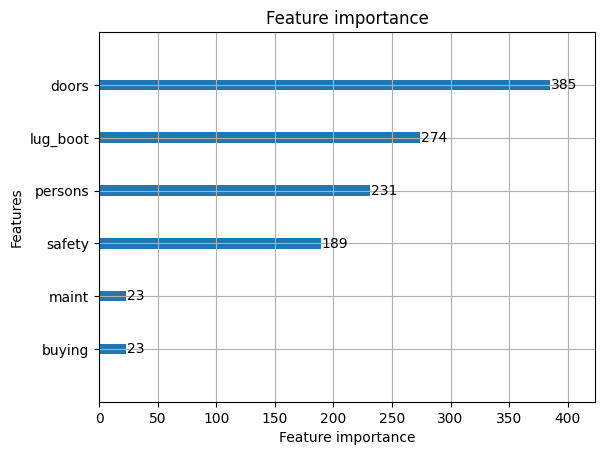

In [27]:
import matplotlib.pyplot as plt

lgb.plot_importance(lgb_model, importance_type='split')
plt.show()

## Optuna

In [28]:
import optuna
from sklearn.model_selection import StratifiedKFold

def objective(trial):

    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': len(np.unique(y)),
        'is_unbalance': 'true',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int("num_leaves", 20, 150),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 20, 100),
        'feature_fraction': trial.suggest_float("feature_fraction", 0.5, 0.9),
        'bagging_fraction': trial.suggest_float("bagging_fraction", 0.5, 0.9),
        'bagging_freq': trial.suggest_int("bagging_freq", 1, 10),
        'lambda_l1': trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        'verbose': -1
    }

    categorical_features = ['lug_boot', 'safety']
    train_data = lgb.Dataset(x_train, label=y_train, categorical_feature=categorical_features)
    test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=10)

    y_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration)
    y_pred_class = [list(pred).index(max(pred)) for pred in y_pred]

    accuracy = accuracy_score(y_test, y_pred_class)

    return accuracy

In [29]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

trial = study.best_trial

print("Accuracy: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2024-11-03 17:50:54,675] A new study created in memory with name: no-name-4766b530-7637-4071-957d-452f05285f47
[I 2024-11-03 17:50:54,743] Trial 0 finished with value: 0.6791907514450867 and parameters: {'learning_rate': 0.027197321754902484, 'num_leaves': 104, 'min_data_in_leaf': 47, 'feature_fraction': 0.894505699302973, 'bagging_fraction': 0.6647611415563787, 'bagging_freq': 4, 'lambda_l1': 6.121676340202521e-08, 'lambda_l2': 0.04074385883670935}. Best is trial 0 with value: 0.6791907514450867.
[I 2024-11-03 17:50:55,140] Trial 1 finished with value: 0.815028901734104 and parameters: {'learning_rate': 0.12938461575663504, 'num_leaves': 74, 'min_data_in_leaf': 97, 'feature_fraction': 0.7443959038420721, 'bagging_fraction': 0.8235193566942719, 'bagging_freq': 4, 'lambda_l1': 0.007770921883101949, 'lambda_l2': 0.03753133791921001}. Best is trial 1 with value: 0.815028901734104.
[I 2024-11-03 17:50:55,421] Trial 2 finished with value: 0.9046242774566474 and parameters: {'learning_rat

Accuracy: 0.9739884393063584
Best hyperparameters: {'learning_rate': 0.2673818143932359, 'num_leaves': 27, 'min_data_in_leaf': 21, 'feature_fraction': 0.7789883754941003, 'bagging_fraction': 0.8458121682997686, 'bagging_freq': 5, 'lambda_l1': 5.026214901404608e-08, 'lambda_l2': 0.013026744088430077}


In [30]:
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

# CMAES

In [32]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import accuracy_score
from cmaes import CMA
from sklearn.model_selection import StratifiedKFold

categorical_features = ['buying', 'maint', 'lug_boot', 'safety']
train_data = lgb.Dataset(x_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)
test_data = lgb.Dataset(x_test, label=y_test, reference=train_data, free_raw_data=False)

initial_params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': len(np.unique(y)),
    'is_unbalance': 'true',
    'boosting_type': 'gbdt',
    'verbose': -1
}

bounds = {
    "learning_rate": (0.01, 0.3),
    "num_leaves": (20, 150),
    "min_data_in_leaf": (20, 100),
    "feature_fraction": (0.5, 0.9),
    "bagging_fraction": (0.5, 0.9),
    "bagging_freq": (1, 10),
    "lambda_l1": (1e-8, 10.0),
    "lambda_l2": (1e-8, 10.0)
}

cma_optimizer = CMA(mean=np.array([0.05, 31, 20, 0.7, 0.7, 5, 1e-2, 1e-2]), sigma=0.3)

def objective_cma(x):
    params = {
        **initial_params,
        "learning_rate": x[0],
        "num_leaves": int(x[1]),
        "min_data_in_leaf": int(x[2]),
        "feature_fraction": x[3],
        "bagging_fraction": x[4],
        "bagging_freq": int(x[5]),
        "lambda_l1": x[6],
        "lambda_l2": x[7]
    }

    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=10)

    y_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration)
    y_pred_class = [list(pred).index(max(pred)) for pred in y_pred]
    accuracy = accuracy_score(y_test, y_pred_class)

    return -accuracy  # CMA-ES minimizes, so return negative accuracy



In [33]:
num_generations = 100
best_accuracy = -float('inf')
best_params = None

for generation in range(num_generations):
    solutions = []

    for _ in range(cma_optimizer.population_size):
        x = cma_optimizer.ask()

        x = np.clip(x, [b[0] for b in bounds.values()], [b[1] for b in bounds.values()])
        loss = objective_cma(x)

        solutions.append((x, loss))

        if -loss > best_accuracy:
            best_accuracy = -loss
            best_params = x

    cma_optimizer.tell(solutions)

print("Best Accuracy:", best_accuracy)
print("Best Hyperparameters:", best_params)

Best Accuracy: 0.9710982658959537
Best Hyperparameters: [ 0.3        30.68303022 21.14787634  0.79418248  0.83567466  4.62927464
  0.08125792  0.05440454]
